<a href="https://colab.research.google.com/github/divyalaldinani/Deep-Learning-in-PyTorch/blob/main/RNN_in_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [52]:
train = pd.read_csv(r"/content/train.csv", dtype=np.float32)
labels = train.label.values

image_data = train.loc[:, train.columns != 'label'].values/255
image_data.min(), image_data.max()

(0.0, 1.0)

In [53]:
image_data.shape # 784 -> pixels in an image, 42000 -> number of images

(42000, 784)

In [54]:
train_data, test_data, train_labels, test_labels = train_test_split(image_data, labels, test_size=0.2, random_state=42)

In [55]:
train_data_torch = torch.from_numpy(train_data)
test_data_torch = torch.from_numpy(test_data)

train_labels_torch = torch.from_numpy(train_labels).type(torch.LongTensor)
test_labels_torch = torch.from_numpy(test_labels).type(torch.LongTensor)

In [56]:
#settings hyperparameters

batch_size = 100
iters = 20000
epochs = iters / (len(train_data)/batch_size)
epochs = int(epochs)
## Note that epochs = number of times the train data is traversed so that all samples are covered, in each epoch, only batch_size number of samples are trained on

In [58]:
train_dataset = TensorDataset(train_data_torch, train_labels_torch)
test_dataset = TensorDataset(test_data_torch, test_labels_torch)

In [59]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

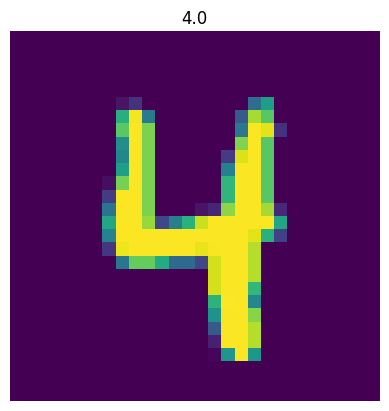

In [60]:
plt.imshow(train_data[80].reshape(28, 28))
plt.axis(False)
plt.title(str(train_labels[80]))
plt.show()

In [61]:
# 1 hidden layer

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_layers, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.hidden_layers = hidden_layers


    self.rnn = nn.RNN(input_size, hidden_size, hidden_layers, batch_first=True, nonlinearity='relu')

    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_size)

    out, hn = self.rnn(x, h0) # out -> contains hidden states of all time stepsfrom the last layer

    out = self.fc(out[:, -1, :]) # out[:, -1, :] -> last hidden layer of seq, out now denotes the output of fc layer by inputtting the output of RNN
    return out

In [62]:
input_size = 28
hidden_size = 100
hidden_layers = 1
output_size = 10 # 10 numbers

model = RNN(input_size, hidden_size, hidden_layers, output_size)

error = nn.CrossEntropyLoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [63]:
losses = []
accuracy = []

for epoch in range(epochs):
    count = 0;
    for i, (images, labels ) in enumerate(train_loader):
        train = images.view(-1, input_size, input_size)
        # labels = labels

        optimizer.zero_grad()

        outputs = model(train)

        loss = error(outputs, labels)
        loss.backward() #backward prop

        optimizer.step() # update params

        count += 1

        if count % 100 == 0 :
            correct = 0
            total = 0

            for images, labels in test_loader:
                images = images.view(-1, input_size, input_size)

                outputs = model(images)
                predictions = torch.max(outputs.data, 1)[1] # .data -> access values, outputs -> (batch_size, num_classes)

                total += images.size(0)
                correct += (predictions == labels).sum()

            acc = 100*float(correct/total)

            accuracy.append(acc)
            losses.append(loss.data)

        if count % 300 == 0:
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {acc}")


Iteration: 300, Loss: 1.2707085609436035, Accuracy: 51.249998807907104
Iteration: 300, Loss: 1.051285743713379, Accuracy: 62.03571557998657
Iteration: 300, Loss: 0.9402324557304382, Accuracy: 66.54762029647827
Iteration: 300, Loss: 0.8690007925033569, Accuracy: 70.79761624336243
Iteration: 300, Loss: 0.7963180541992188, Accuracy: 74.48809742927551
Iteration: 300, Loss: 0.7510060667991638, Accuracy: 76.5238106250763
Iteration: 300, Loss: 0.7072566151618958, Accuracy: 78.15476059913635
Iteration: 300, Loss: 0.6571023464202881, Accuracy: 80.48809766769409
Iteration: 300, Loss: 0.6064454913139343, Accuracy: 82.03571438789368
Iteration: 300, Loss: 0.5704972147941589, Accuracy: 83.29761624336243
Iteration: 300, Loss: 0.5371761918067932, Accuracy: 84.28571224212646
Iteration: 300, Loss: 0.5250203609466553, Accuracy: 84.96428728103638
Iteration: 300, Loss: 0.5058622360229492, Accuracy: 85.69047451019287
Iteration: 300, Loss: 0.4813905954360962, Accuracy: 86.28571629524231
Iteration: 300, Loss:

In [64]:
lr

0.0001

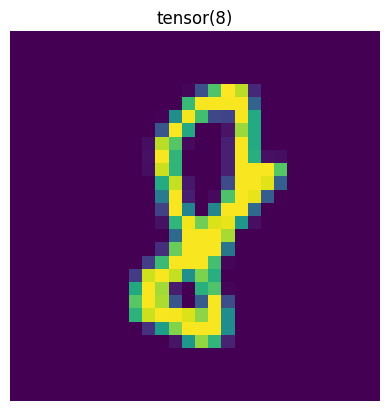

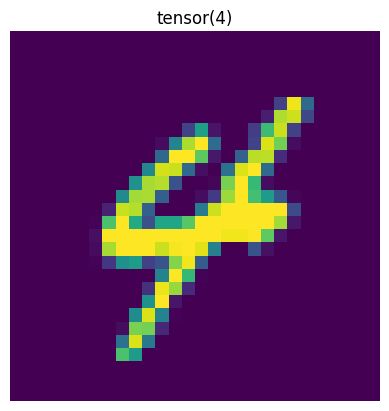

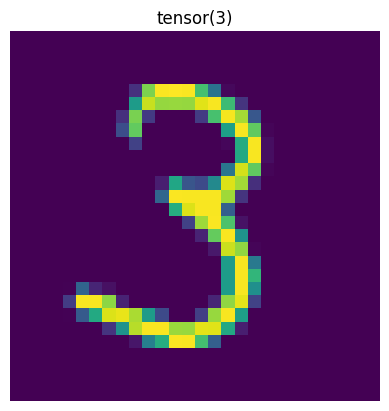

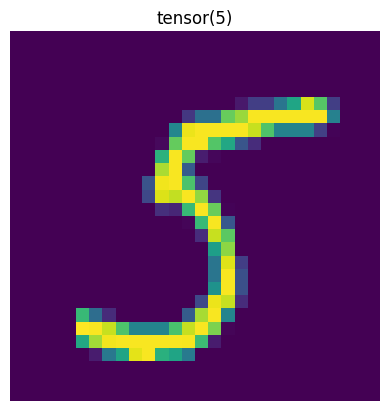

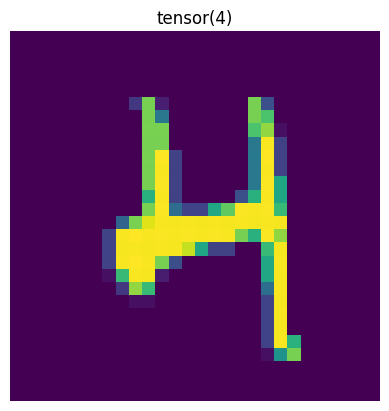

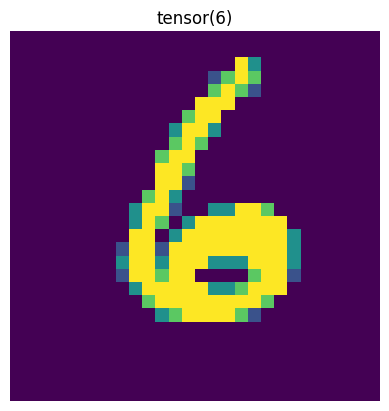

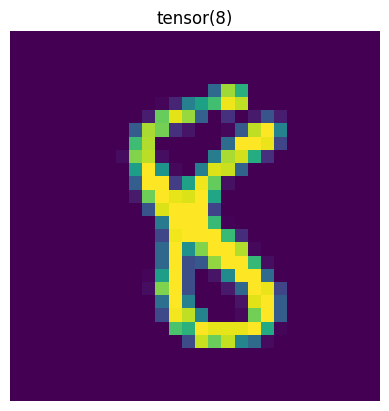

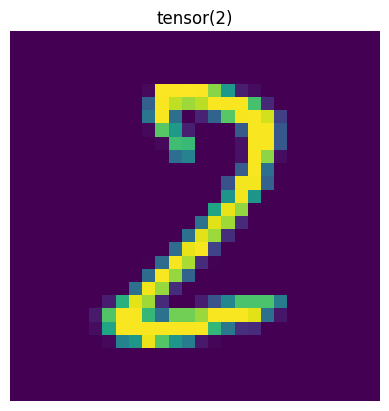

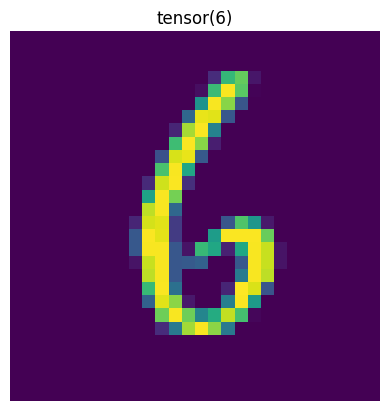

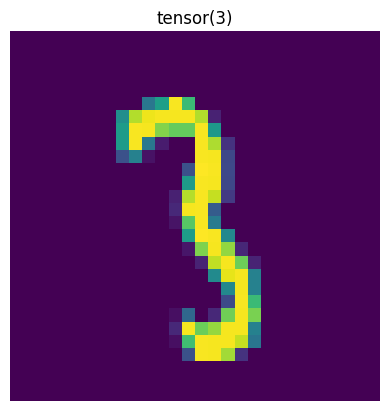

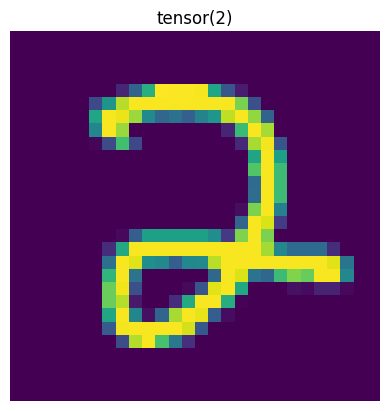

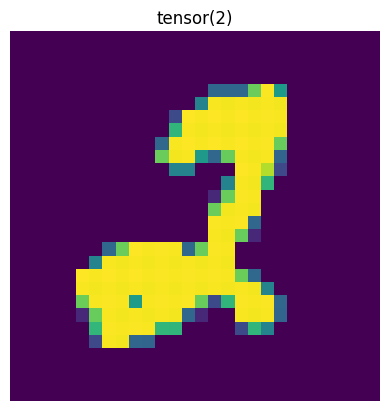

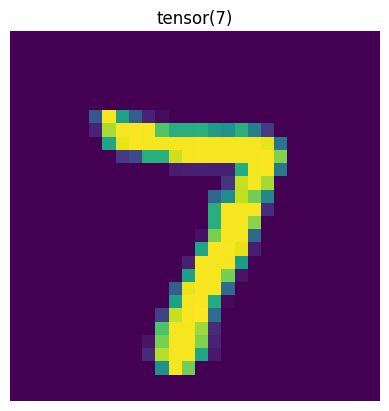

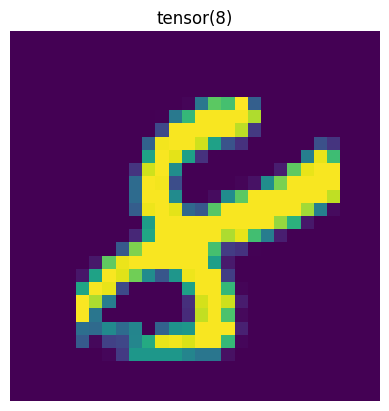

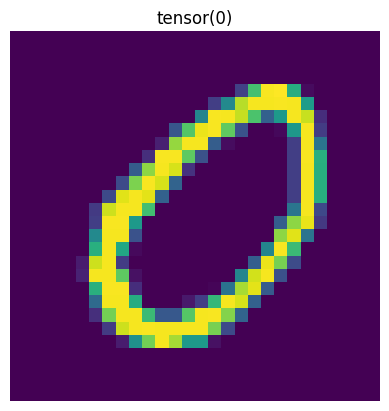

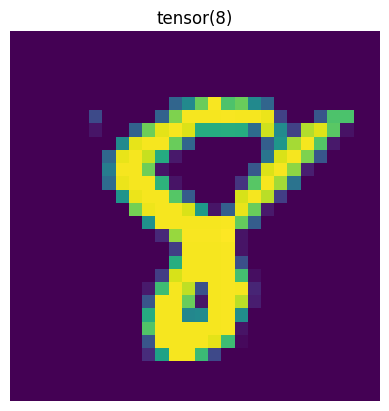

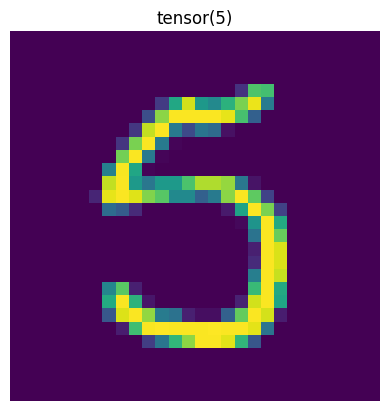

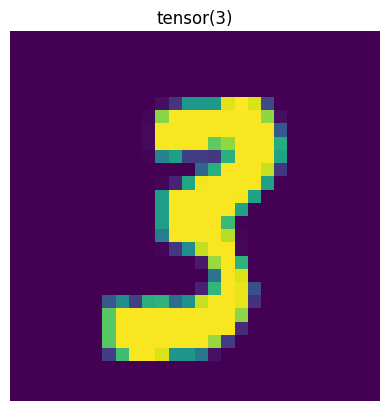

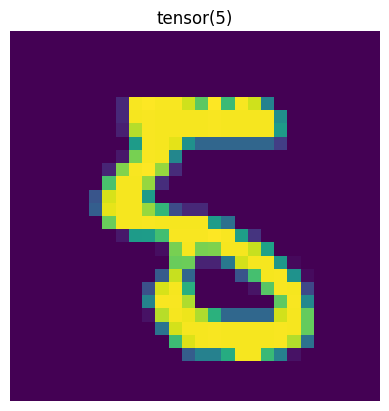

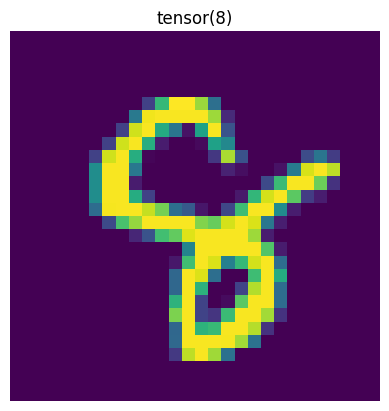

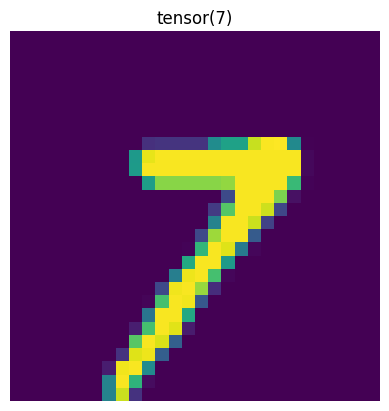

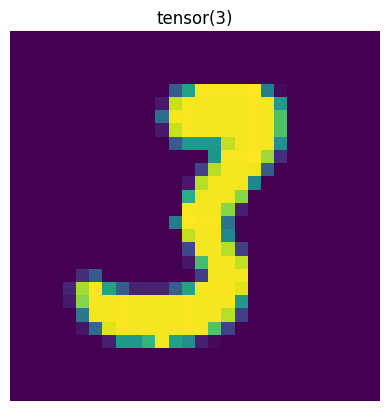

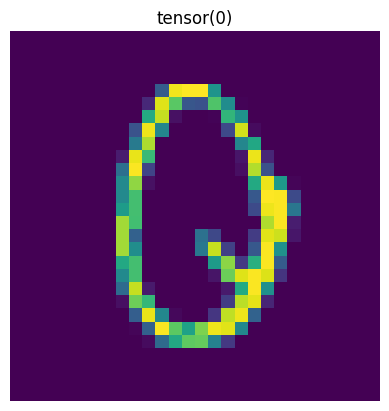

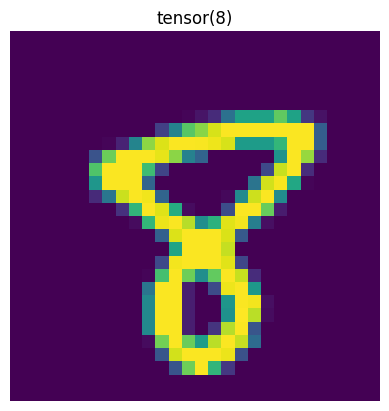

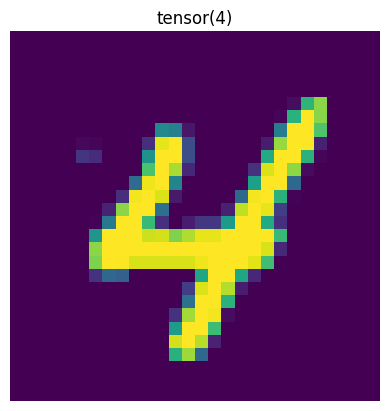

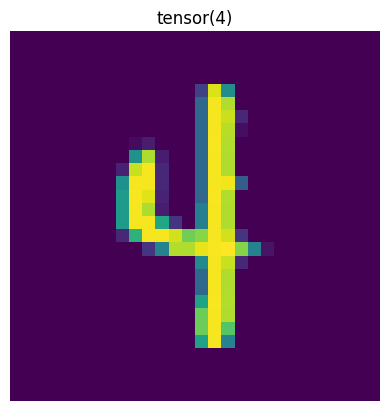

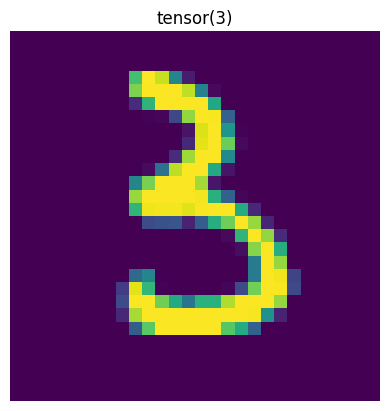

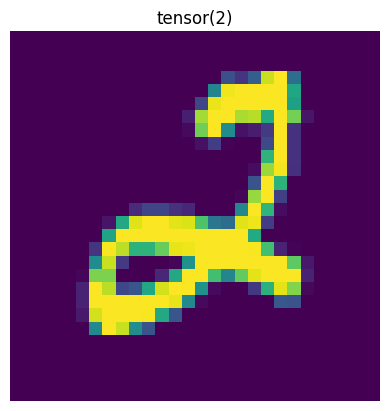

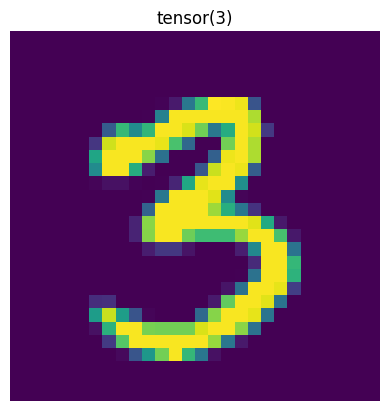

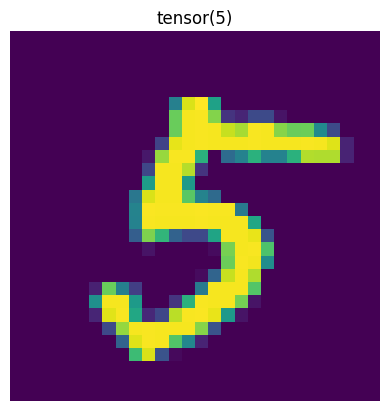

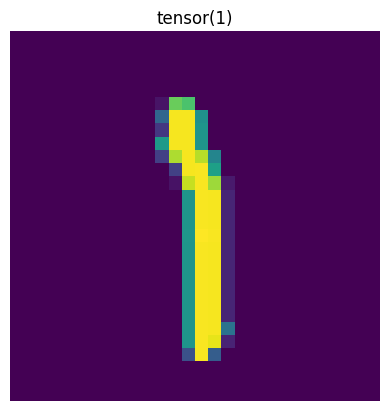

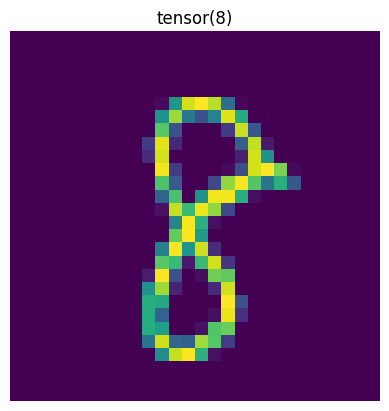

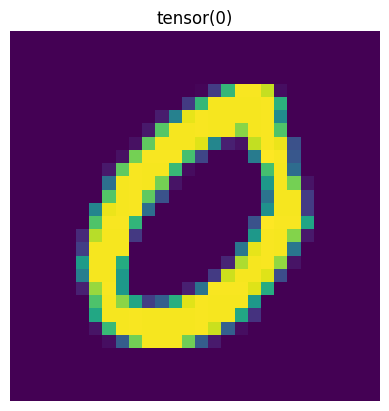

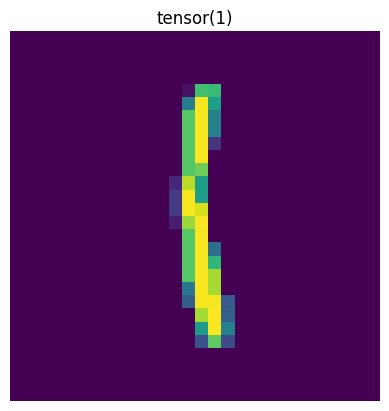

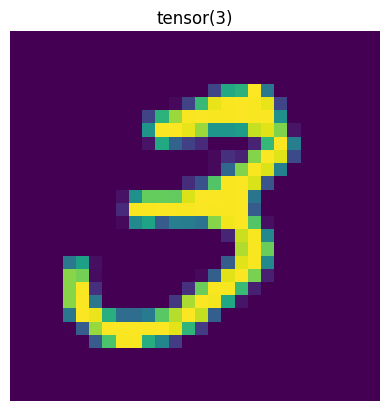

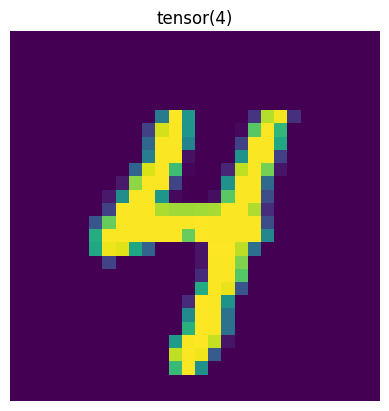

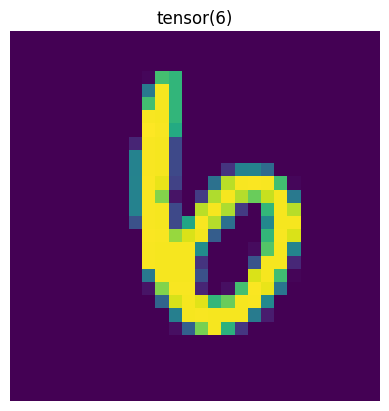

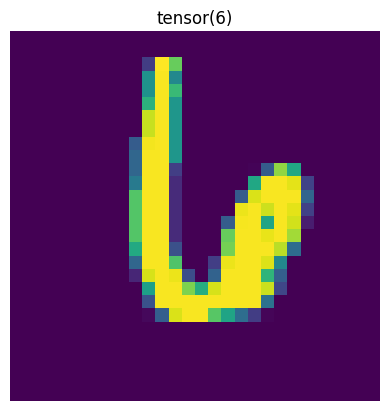

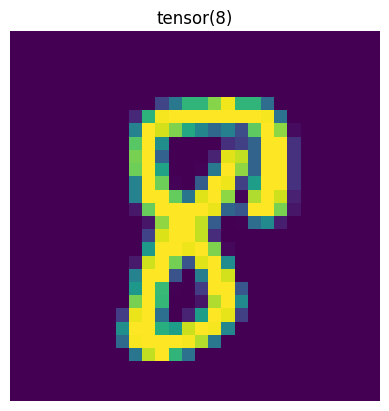

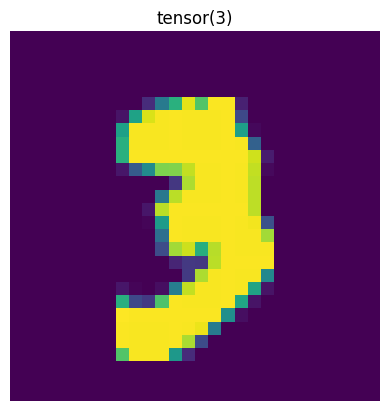

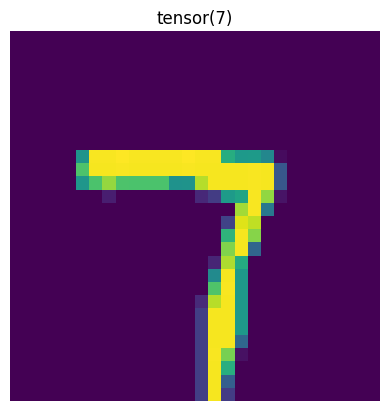

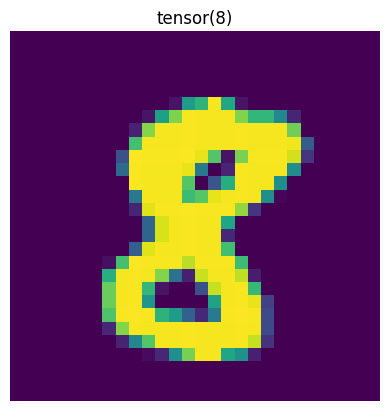

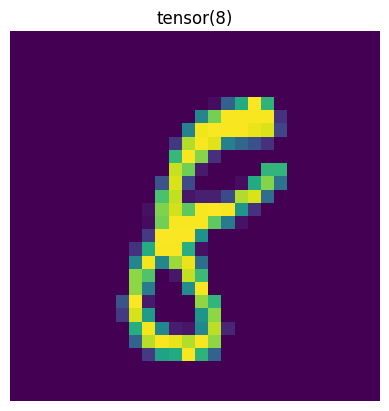

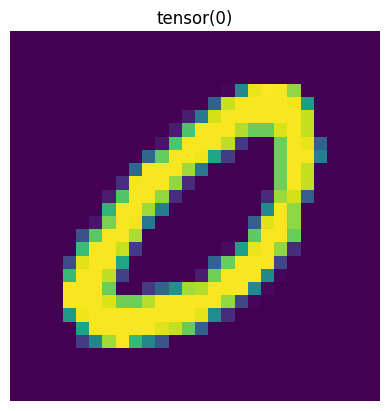

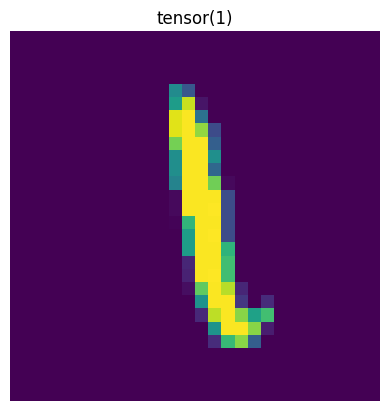

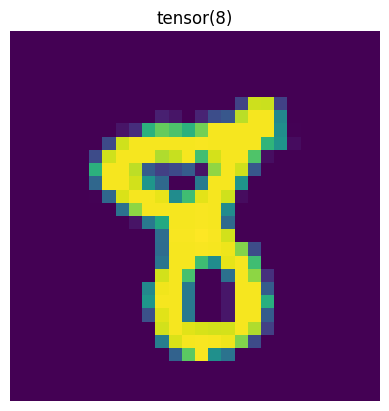

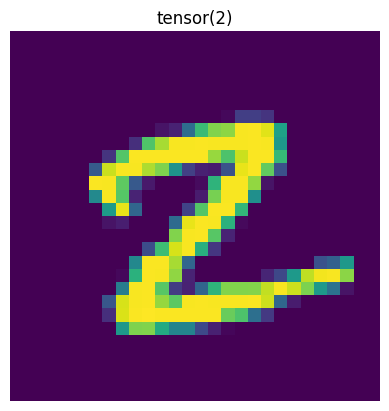

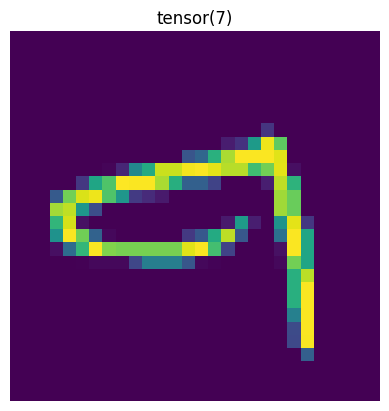

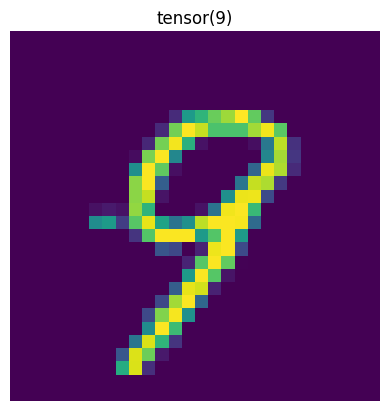

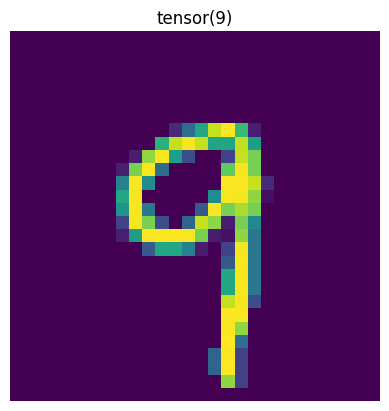

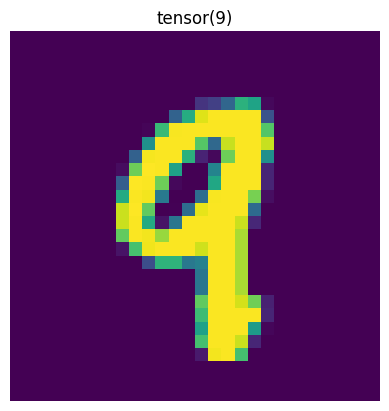

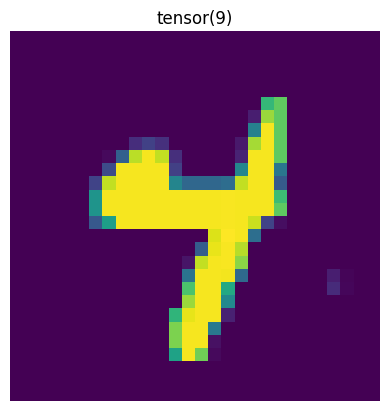

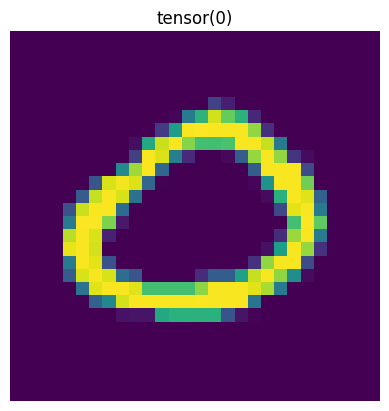

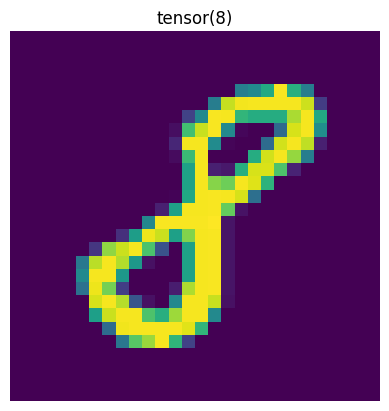

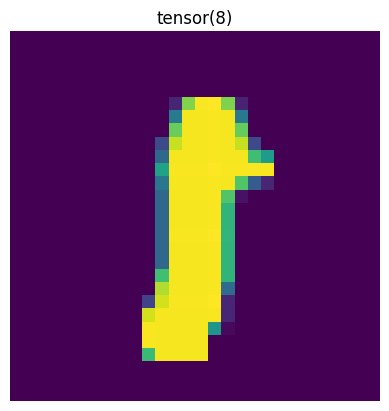

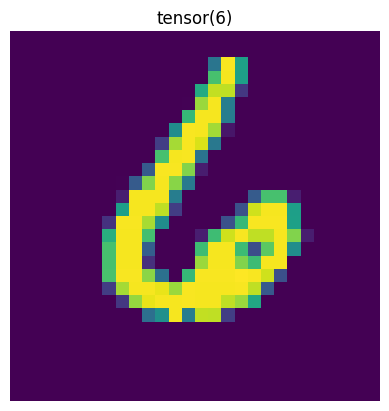

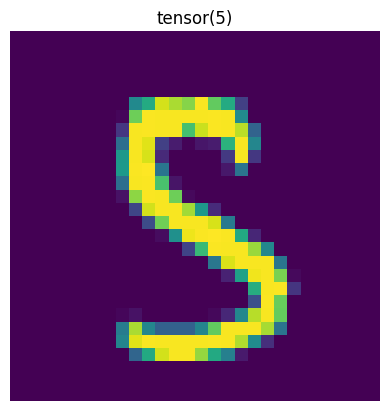

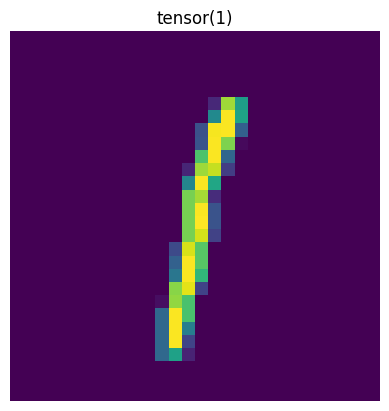

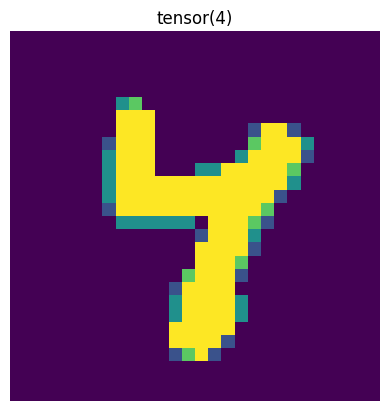

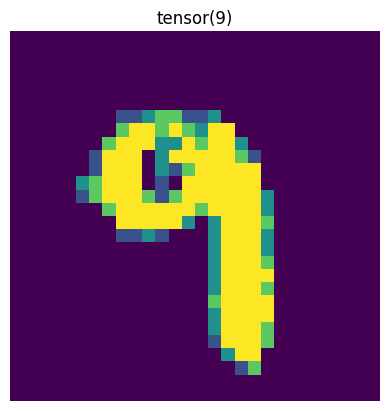

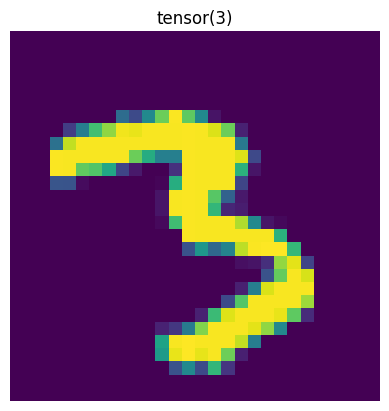

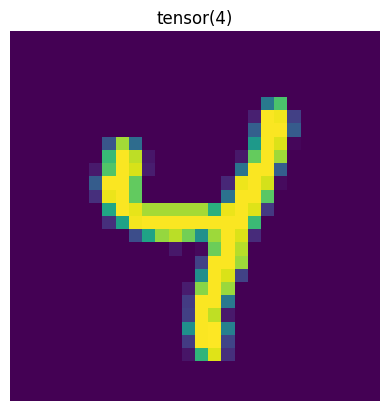

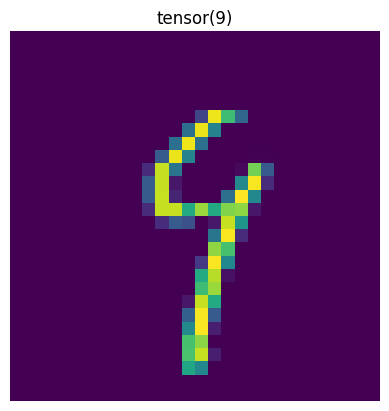

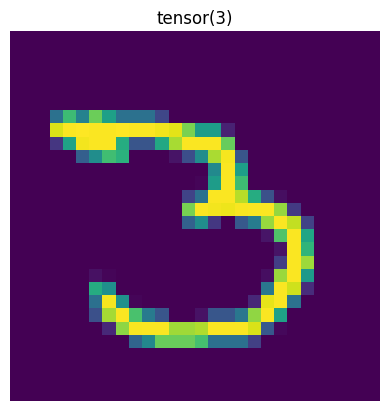

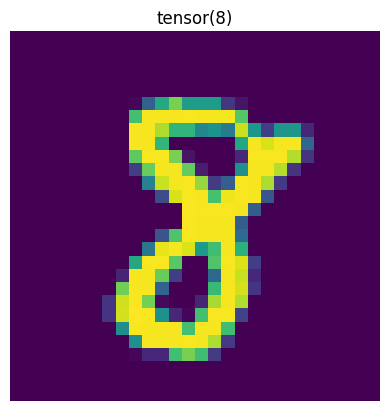

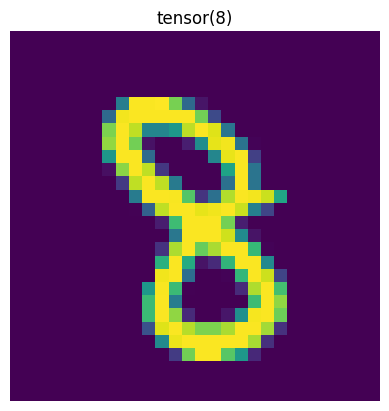

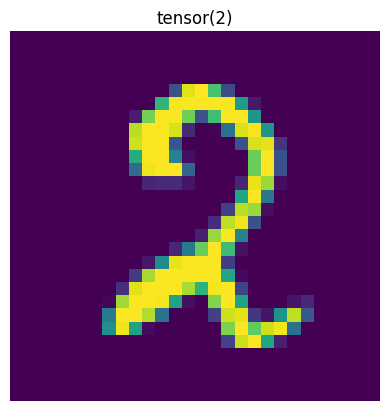

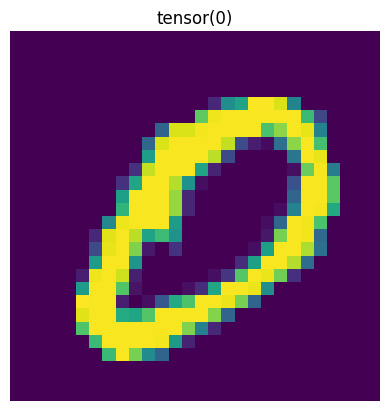

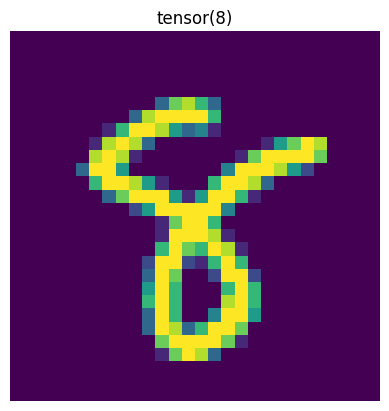

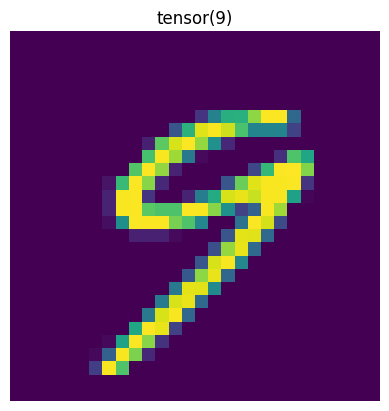

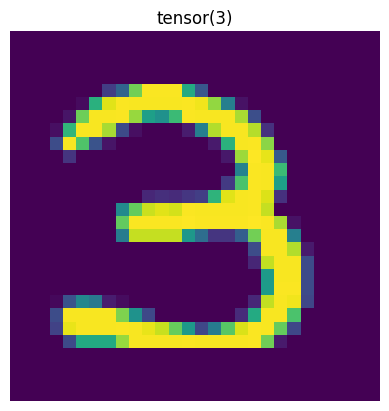

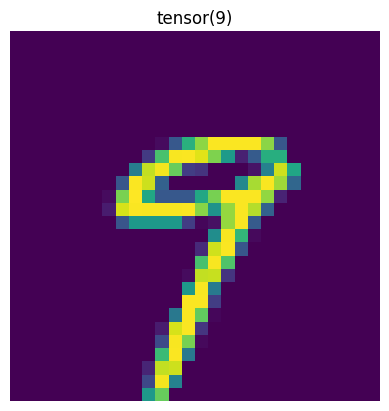

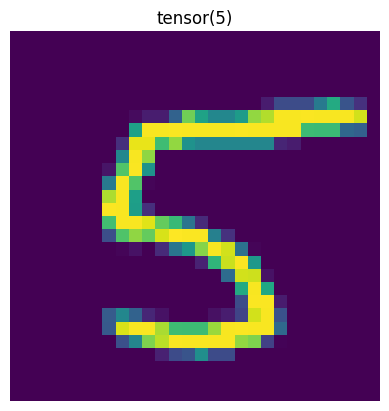

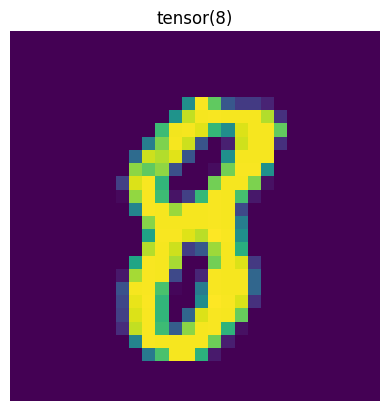

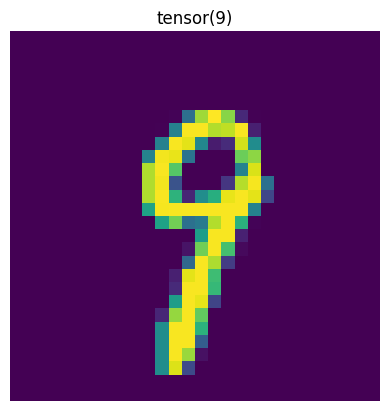

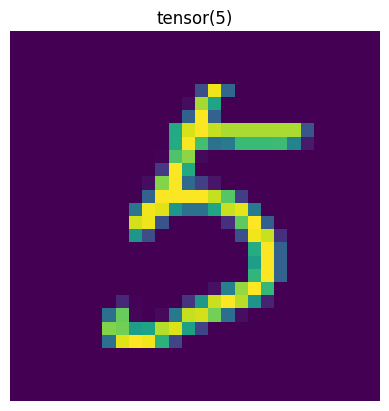

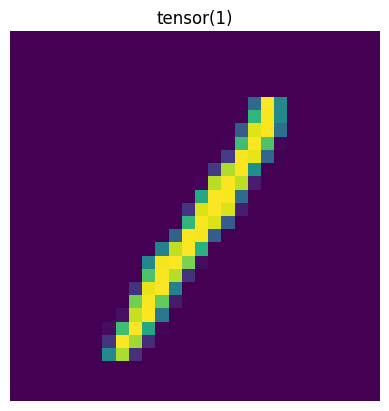

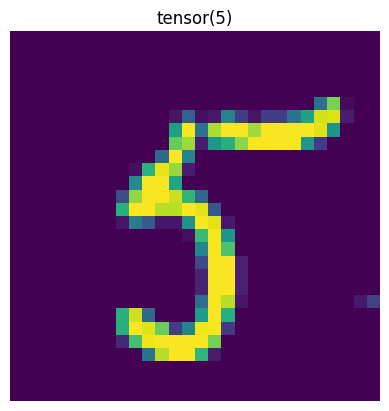

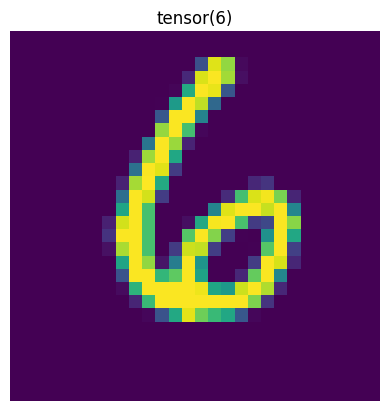

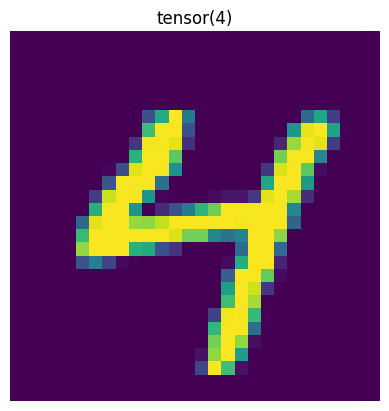

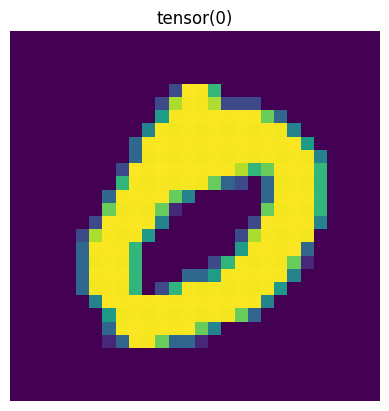

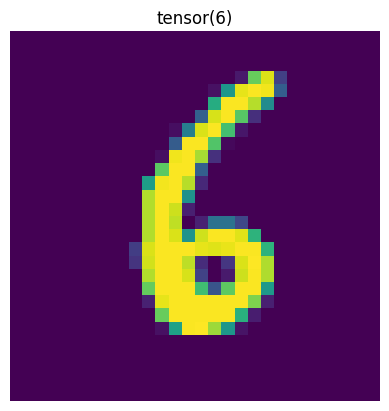

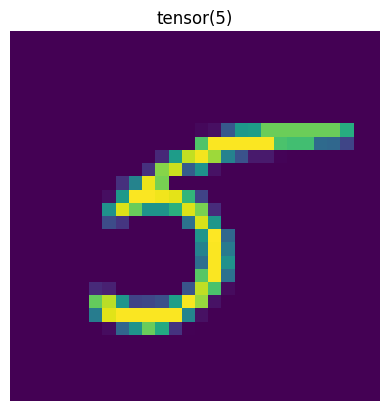

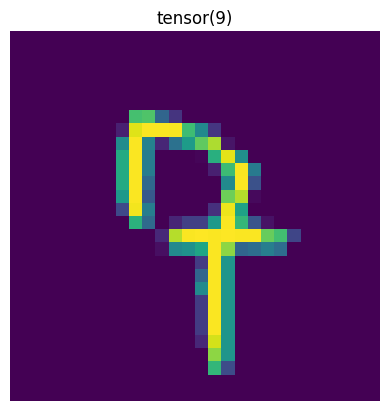

In [69]:
for images, labels in test_loader:
    images = images.view(-1, input_size, input_size)
    outputs = model(images)
    predictions = torch.max(outputs.data, 1)[1]

    num_images = images.shape[0]
    for image_idx in range(1):
        plt.imshow(images[image_idx])
        plt.axis('off')
        plt.title(predictions[image_idx])
        plt.show()


In [66]:
test = pd.read_csv('test.csv')
predictions = []
image_data = test.loc[:, :].values/255
i = 1
image_data = torch.tensor(image_data)
for image in image_data:
  image = image.view(input_size, input_size)
  # print(image.shape)
  image = torch.tensor(image, dtype=torch.float32)
  preds = model(image.unsqueeze(0))
  preds = torch.max(preds.data, 1)[1]
  predictions.append({'ImageId': i, 'Label': preds[0].item()})
  i+=1

<ipython-input-66-a05bb63ca0cb>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


In [67]:
df = pd.DataFrame(predictions)
df.to_csv('predictions.csv', index=False)